In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to dataset
train_dir = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
val_dir = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 30

# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Number of classes
num_classes = len(train_generator.class_indices)

# Function to build a fine-tuned model
def build_model(base_model, dropout_rate=0.5):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Fine-tune the model
def fine_tune_model(model, base_model, trainable_layers=30):
    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Found 924 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


In [13]:
# Build and fine-tune models
resnet_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_model = build_model(resnet_base)
resnet_model = fine_tune_model(resnet_model, resnet_base, trainable_layers=30)

vgg_model = build_model(vgg_base)
vgg_model = fine_tune_model(vgg_model, vgg_base, trainable_layers=10)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [14]:
# Train ResNet101V2
print("Training ResNet101V2...")
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Train VGG19
print("Training VGG19...")
vgg_history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


Training ResNet101V2...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 898ms/step - accuracy: 0.1240 - loss: 2.7290 - val_accuracy: 0.2961 - val_loss: 1.9097 - learning_rate: 1.0000e-05
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1704 - loss: 2.5365 - val_accuracy: 0.4120 - val_loss: 1.7021 - learning_rate: 1.0000e-05
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.1755 - loss: 2.3803 - val_accuracy: 0.5107 - val_loss: 1.5500 - learning_rate: 1.0000e-05
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 375ms/step - accuracy: 0.1986 - loss: 2.2402 - val_accuracy: 0.6009 - val_loss: 1.4318 - learning_rate: 1.0000e-05
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.2831 - loss: 2.0991 - val_accuracy: 0.6309 - val_loss: 1.3244 - learning_rate: 1.0000e-05
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.2890 - loss: 1.9845 - val_accuracy: 0.6781 - val_loss: 1.2216 - learning_rate: 1.0000e-05
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 375ms/step - accuracy: 0.34

In [15]:
# Ensemble predictions
def get_predictions(model, data_generator):
    return model.predict(data_generator)

resnet_preds = get_predictions(resnet_model, val_generator)
vgg_preds = get_predictions(vgg_model, val_generator)
ensemble_preds = (resnet_preds + vgg_preds) / 2
ensemble_classes = np.argmax(ensemble_preds, axis=1)

# True labels
true_labels = val_generator.classes
class_names = list(val_generator.class_indices.keys())



8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 843ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step


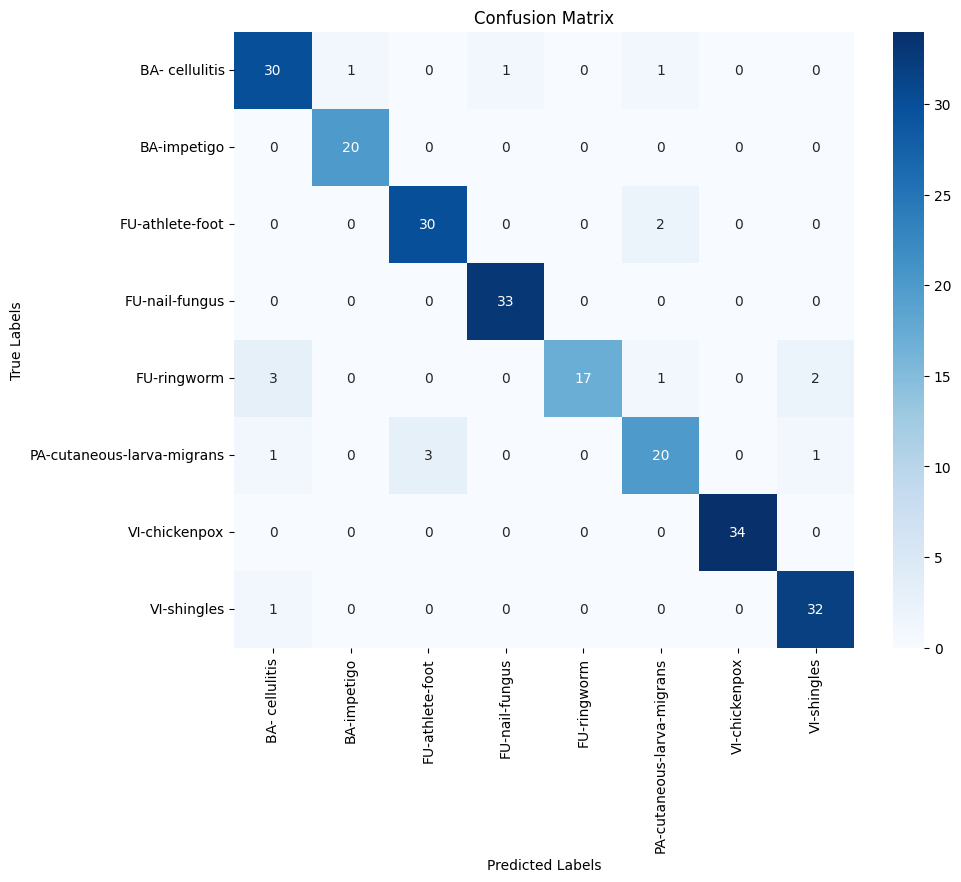

Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.86      0.91      0.88        33
               BA-impetigo       0.95      1.00      0.98        20
           FU-athlete-foot       0.91      0.94      0.92        32
            FU-nail-fungus       0.97      1.00      0.99        33
               FU-ringworm       1.00      0.74      0.85        23
PA-cutaneous-larva-migrans       0.83      0.80      0.82        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       0.91      0.97      0.94        33

                  accuracy                           0.93       233
                 macro avg       0.93      0.92      0.92       233
              weighted avg       0.93      0.93      0.93       233

Ensemble Log Loss: 0.7603
Ensemble Accuracy: 0.9270


In [16]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, ensemble_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_labels, ensemble_classes, target_names=class_names))

# Ensemble accuracy and log loss
ensemble_loss = log_loss(true_labels, ensemble_preds)
ensemble_accuracy = np.sum(ensemble_classes == true_labels) / len(true_labels)

print(f"Ensemble Log Loss: {ensemble_loss:.4f}")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
